In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# import google drive
from google.colab import drive
import zipfile, os

# mounting drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# extracting frames
local_zip = '/content/drive/MyDrive/crowd counting dataset/frames.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
# each image has a label that represent how many people inside the room

label_df = pd.read_csv('/content/drive/MyDrive/crowd counting dataset/label_frame.csv') # mounting the labels

label_df.columns = ['id', 'people'] # adding id and people to columns

label_df.head()


,id,people
0,1,35
1,2,41
2,3,41
3,4,44
4,5,41


In [ ]:
# moving extracted frames to label folder
import shutil, os

frames = os.listdir('/content/frames') # get all files from frames directory
os.mkdir('/content/labeled_frame') # make labeled_frame folder
os.mkdir('/content/labeled_frame/ramai') # make labeled_frame ramai folder
os.mkdir('/content/labeled_frame/tidak_ramai') # make labeled_frame tidak_ramai folder

# label_df.to_numpy() convert from pandas dataframe to numpy array
for row in label_df.to_numpy():
  id = str(row[0]) # get the id
  file_name = f'seq_{id.zfill(6)}.jpg' # fill the id to match the filename
  people = row[1] # get the count label

  if people > 40:
    shutil.move(f'/content/frames/{file_name}', '/content/labeled_frame/ramai')
  else:
    shutil.move(f'/content/frames/{file_name}', '/content/labeled_frame/tidak_ramai')

In [ ]:
print(len(os.listdir('/content/labeled_frame/ramai')))
print(len(os.listdir('/content/labeled_frame/tidak_ramai')))

222
1778


In [ ]:
# to prevent model from overfitting, we need to generate more image for class ramai
from random import randint

for i in range(1476):
  ramai = os.listdir('/content/labeled_frame/ramai')
  file_name = ramai[randint(0, len(ramai)-1)]
  file_src = f'/content/labeled_frame/ramai/'+file_name
  file_dest = file_src[:-4] + f'({i})' + file_src[-4:]
  shutil.copy2(file_src, file_dest)

In [ ]:
print(len(os.listdir('/content/labeled_frame/ramai')))
print(len(os.listdir('/content/labeled_frame/tidak_ramai')))

1698
1778


In [ ]:
# making image data generator to do image processing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    # fill_mode='nearest',
    validation_split=0.4 # splitting 40% of the train data to be used as validation
)

In [ ]:
# shutil.rmtree('/content/labeled_frame/.ipynb_checkpoints')

train_dir = '/content/labeled_frame'
validation_dir = '/content/labeled_frame'

# generate train data with training subset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(480, 640),
    batch_size=4,
    class_mode='binary',
    subset='training'
)

# validation data dengan subset validation
validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=(480, 640),
    batch_size=4,
    class_mode='binary',
    subset='validation'
)

Found 2086 images belonging to 2 classes.
Found 1390 images belonging to 2 classes.


In [ ]:
# define model layers
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape=(480, 640, 3)),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Conv2D(64, (2, 2), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Conv2D(128, (2, 2), activation='relu'),
                                    tf.keras.layers.MaxPooling2D(2, 2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.Dense(128, activation='relu'),
                                    tf.keras.layers.Dense(256, activation='relu'),
                                    tf.keras.layers.Dense(256, activation='relu'),
                                    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 479, 639, 32)      416       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 239, 319, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 238, 318, 64)      8256      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 119, 159, 64)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 118, 158, 128)     32896     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 59, 79, 128)       0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 596608)           

In [ ]:
# compile model with adam optimizer and binary_crossentropy loss function
model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=1e-6),
              metrics=['accuracy'])

In [ ]:
# training model
history = model.fit(
      train_generator,
      steps_per_epoch=25,  # specify batch per epoch
      epochs=50,
      validation_data=validation_generator, # fill validation data using validation_generator 
      validation_steps=5,
      verbose=2)

Epoch 1/50
25/25 - 11s - loss: 0.6936 - accuracy: 0.5000 - val_loss: 0.6892 - val_accuracy: 0.7500
Epoch 2/50
25/25 - 9s - loss: 0.6940 - accuracy: 0.5100 - val_loss: 0.6961 - val_accuracy: 0.3500
Epoch 3/50
25/25 - 9s - loss: 0.6934 - accuracy: 0.4800 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 4/50
25/25 - 10s - loss: 0.6934 - accuracy: 0.4900 - val_loss: 0.6942 - val_accuracy: 0.3500
Epoch 5/50
25/25 - 10s - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6952 - val_accuracy: 0.4000
Epoch 6/50
25/25 - 10s - loss: 0.6942 - accuracy: 0.4800 - val_loss: 0.6897 - val_accuracy: 0.6000
Epoch 7/50
25/25 - 9s - loss: 0.6928 - accuracy: 0.5000 - val_loss: 0.6967 - val_accuracy: 0.3500
Epoch 8/50
25/25 - 9s - loss: 0.6933 - accuracy: 0.5300 - val_loss: 0.6922 - val_accuracy: 0.4500
Epoch 9/50
25/25 - 9s - loss: 0.6905 - accuracy: 0.5800 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 10/50
25/25 - 9s - loss: 0.6944 - accuracy: 0.4900 - val_loss: 0.6869 - val_accuracy: 0.6500
Epoch 11/50
25/

In [ ]:
_, acc = model.evaluate(validation_generator, steps=len(validation_generator), verbose=0)

In [ ]:
print('Accuracy =>', str(int(acc*100))+'%')

Accuracy => 95%


Saving seq_000003.jpg to seq_000003 (1).jpg
seq_000003.jpg
tidak ramai


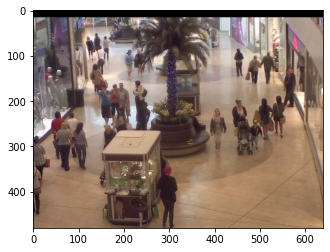

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(480,640))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)
  if classes==0:
    print('ramai')
  else:
    print('tidak ramai')

Saving seq_000001.jpg to seq_000001 (22).jpg
Saving seq_000002.jpg to seq_000002 (17).jpg


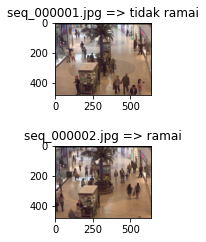

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()
 
sub = 210

for fn in uploaded.keys():
  sub += 1
  plt.subplot(sub)
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(480,640))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  if classes==0:
    prediction = 'ramai'
  else:
    prediction = 'tidak ramai'

  plt.tight_layout(pad=3)

  plt.title(f'{fn} => {prediction}')
